<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/Lecture3_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![대체 텍스트](https://raw.githubusercontent.com/deepnoid/education/master/7.%20Deep%20Learning%20Keras/dataset/deepnoid_logo.jpg)

In [ ]:
!git clone https://github.com/MOOSUNGPARK/education.git

Cloning into 'education'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 98 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (98/98), done.


# 모듈 불러오기

In [ ]:
from keras import applications, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from skimage.transform import rotate
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


# 경로 설정하기

In [ ]:
BASE_PATH = r'./education/KH/dataset/classification'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'Open_I_abd_vs_CXRs', 'TRAIN')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'Open_I_abd_vs_CXRs', 'VAL')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'Open_I_abd_vs_CXRs', 'TEST', 'abd2.png')

In [ ]:
TRAIN_DATA_PATH

'./education/KH/dataset/classification/Open_I_abd_vs_CXRs/TRAIN'

# 하이퍼 파라미터

하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다.  
주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [ ]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
EPOCHS = 10
BATCH_SIZE = 5
LEARNING_RATE = 1e-4
DECAY_RATE = 0

# 데이터 불러오기

AI 모델 학습에 사용할 데이터를 불러오겠습니다.  
케라스의 **ImageDataGenerator** 함수를 사용해 손쉽게 데이터를 불러올 수 있습니다.  


또한 데이터를 불러올 때 옵션을 활용해 **Augmentation** 도 할 수 있습니다.

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

**flow_from_directory** 함수는 지정해둔 폴더 내의 이미지와 레이블을 자동으로 불러오는 함수입니다.  
이 함수를 이용해 훈련 데이터와 검증 데이터를 불러오겠습니다.

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_PATH,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory=VAL_DATA_PATH,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=1,
                                                class_mode='binary',
                                                shuffle=False,
                                                seed=42)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


# 데이터 전처리

데이터를 불러온 후 AI 모델의 성능을 높일 수 있는 몇 가지 전처리를 진행합니다.  
특히 절대적인 데이터 양이 부족한 의료 인공지능 훈련 시에는  
데이터 양을 **Augmentation** 기술을 이용해 늘릴 수 있습니다. 

먼저 원본 이미지의 특징은 다음과 같습니다.

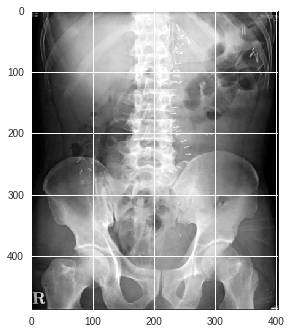

In [ ]:
img = plt.imread(TEST_DATA_PATH)
plt.imshow(img, cmap='Greys')
plt.show()

이미지의 형태는 (489, 404, 3) 으로  
세로 **489** 가로 **404** 채널 **3(RGB)** 의 이미지를 불러왔다는 의미입니다.

In [ ]:
np.shape(img)

(489, 404, 3)

그리고 위 이미지를 컴퓨터가 실제로 인식하는 숫자 데이터로 확인해보겠습니다.

In [ ]:
img

array([[[0.14117648, 0.14117648, 0.14117648],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.12941177, 0.12941177, 0.12941177],
        ...,
        [0.12941177, 0.12941177, 0.12941177],
        [0.12941177, 0.12941177, 0.12941177],
        [0.14117648, 0.14117648, 0.14117648]],

       [[0.1254902 , 0.1254902 , 0.1254902 ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.12941177, 0.12941177, 0.12941177]],

       [[0.13333334, 0.13333334, 0.13333334],
        [0.08235294, 0.08235294, 0.08235294],
        [0.08235294, 0.08235294, 0.08235294],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.03137255, 0.03137255, 0.03137255],
        [0.12941177, 0.12941177, 0.12941177]],

       ...,

       [[0.13725491, 0.13725491, 0.13725491],
        [0.04313726, 0.04313726, 0.04313726],
        [0.03921569, 0

Augmentation 은 위와 같이 숫자로 이루어진 이미지 데이터를 가공하여  
원본과 유사하지만 다른 새로운 이미지를 만드는 기법입니다.

이 중 **로테이션 기법** 을 살펴보겠습니다. 

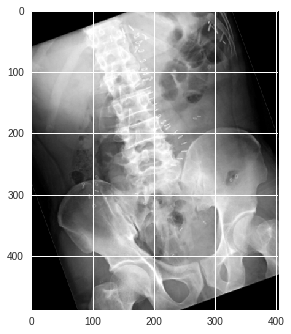

In [ ]:
img_rot = rotate(img, 20)
plt.imshow(img_rot)
plt.show()

다음으로 **이동** 기법을 살펴보겠습니다.

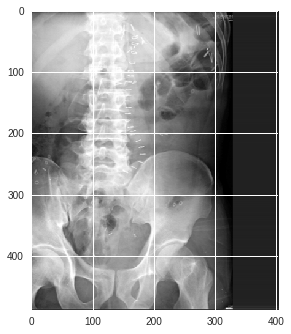

In [ ]:
img_shift = image.random_shift(img, 0.2, 0.2)
plt.imshow(img_shift)
plt.show()

**감마 변경** 도 해봅시다.

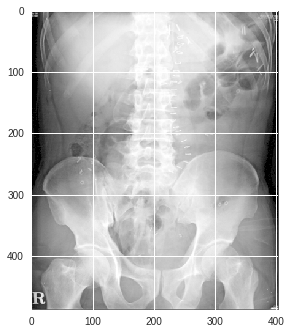

In [ ]:
img_gamma = exposure.adjust_gamma(img, gamma=0.5)
plt.imshow(img_gamma)
plt.show()

**좌우 반전** 은 다음과 같습니다.

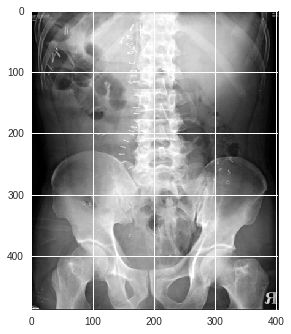

In [ ]:
img_hflip = np.fliplr(img)
plt.imshow(img_hflip)
plt.show()

다음으로 **상하 반전** 을 확인해보겠습니다.

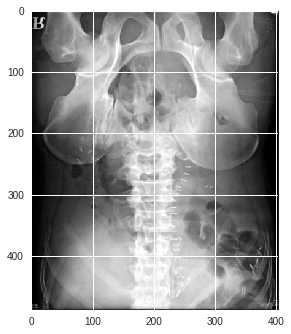

In [ ]:
img_vflip = np.flipud(img)
plt.imshow(img_vflip)
plt.show()

그렇다면 이 모든 기법을 동시에 적용해볼까요?  
처음 이미지와 상당히 다른 새로운 이미지가 만들어집니다.

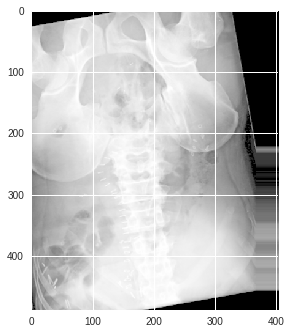

In [ ]:
img_rot = rotate(img, 10)
img_shift = image.random_shift(img_rot, 0.1, 0.1)
img_gamma = exposure.adjust_gamma(img_shift, gamma=0.3)
img_hflip = np.fliplr(img_gamma)
img_vflip = np.flipud(img_hflip)
plt.imshow(img_vflip)
plt.show()

# **X-ray 이미지 구분하는 AI 모델 만들기**

AI 모델을 만드는 방법은 크게  

1) 모듈에서 제공하는 이미 훈련된 모델을 불러오는 방법과  
2) 자신만의 새로운 모델을 만드는 방법이 있습니다.

저희의 모델을 만들기 전에 우선 손쉽게 사용할 수 있도록 **이미 훈련된 모델을 사용** 해보겠습니다.  
가볍고 성능이 좋아 자주 사용되는 **Inception 모델** 을 불러오겠습니다.

In [ ]:
basemodel = applications.inception_v3.InceptionV3(weights='imagenet',
                                                  include_top=False,
                                                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model_top = Sequential()
model_top.add(GlobalAveragePooling2D())
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))



model = Model(inputs=basemodel.input, outputs=model_top(basemodel.output))
model.compile(optimizer=Adam(lr=LEARNING_RATE,
                             epsilon=1e-8,
                             decay=DECAY_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
_______________________________________________________

1. score 그대로 내보내는 방법 : 구체적인 값이 필요한 경우(강수확률, 주가 예측, 복권 당첨 확률)
2. 0~1사이의 값으로 -> sigmoid : (None, 1) -> 0~1 줄 세우기, 0또는1 binary classification
3. (None, 3) 으로 나타내기 -> softmax : [0.51, 1.25, 3.12] -> 포도 (rgb, 국영수사과, 사과 배 포도)
(None, 2) [0.2, 1.6] -> abdo

# AI 모델 훈련하기

이렇게 준비한 AI 모델을 fit_generator 함수를 이용해 훈련시킬 수 있습니다.

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=val_generator.n // BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
13/13 [==============================] - 80s 6s/step - loss: 0.4862 - acc: 0.7385 - val_loss: 0.0359 - val_acc: 1.0000
Epoch 2/10
13/13 [==============================] - 62s 5s/step - loss: 0.2482 - acc: 0.9231 - val_loss: 0.0202 - val_acc: 1.0000
Epoch 3/10
13/13 [==============================] - 62s 5s/step - loss: 0.0987 - acc: 0.9538 - val_loss: 0.0293 - val_acc: 1.0000
Epoch 4/10
13/13 [==============================] - 62s 5s/step - loss: 0.1509 - acc: 0.9692 - val_loss: 0.0153 - val_acc: 1.0000
Epoch 5/10
13/13 [==============================] - 62s 5s/step - loss: 0.2951 - acc: 0.8923 - val_loss: 0.0292 - val_acc: 1.0000
Epoch 6/10
13/13 [==============================] - 62s 5s/step - loss: 0.0656 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 7/10
13/13 [==============================] - 62s 5s/step - loss: 0.0592 - acc: 0.9846 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 8/10
13/13 [========================

# 훈련 결과 확인하기

훈련 결과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 **y축에 사용할 값**들을 **history 항목**에서 추출해 봅시다.

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 **x축 값**으로 사용할 **epoch** 을 뽑아 보겠습니다.

In [ ]:
epochs = range(len(acc))

값들을 확인해볼까요?

In [ ]:
acc

[0.7384615460267434,
 0.9230769276618958,
 0.9538461565971375,
 0.9692307710647583,
 0.8923076941416814,
 1.0,
 0.9846153855323792,
 0.9692307710647583,
 1.0,
 0.9538461565971375]

In [ ]:
val_acc

In [ ]:
loss

[0.4862179056956218,
 0.24819941704089826,
 0.09865011718983833,
 0.15094372587135205,
 0.2951493996840257,
 0.06557489551890355,
 0.05921901705173346,
 0.1502224924401022,
 0.05745566485879513,
 0.0593010143448527]

In [ ]:
val_loss

[0.035853536799550056,
 0.020230843278113753,
 0.029327949399885256,
 0.015280656050890684,
 0.02918860944919288,
 0.0057903798297047615,
 0.0019201143004465848,
 0.014138770784484223,
 0.01645299606025219,
 0.0029081382672302425]

In [ ]:
list(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

이 값들을 이용해 그래프를 만들어 보겠습니다.

먼저 정확도 그래프를 그려볼까요?

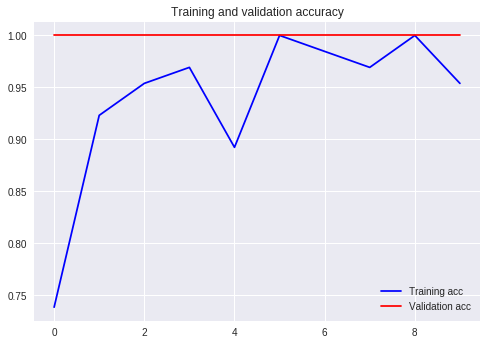

In [ ]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

다음으로 손실 그래프를 살펴보겠습니다.

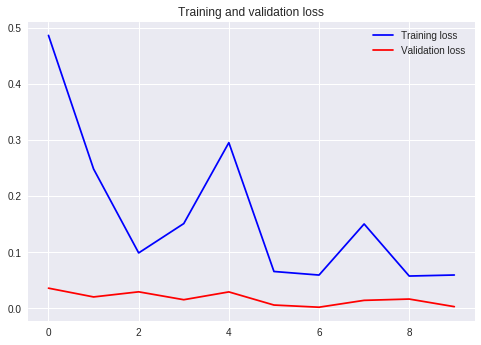

In [ ]:
plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 테스트하기

마지막으로 AI 모델이 실제로 X-ray 이미지를 잘 분류하는지 확인해보겠습니다.

먼저 미리 준비한 테스트 이미지 경로를 입력한 후,

In [ ]:
img1_path = './education/KH/dataset/classification/Open_I_abd_vs_CXRs/TEST/chest1.png'
img2_path = './education/KH/dataset/classification/Open_I_abd_vs_CXRs/TEST/abd2.png'

load_img 함수를 이용해 이미지를 불러옵니다.

In [ ]:
img1 = image.load_img(img1_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img2 = image.load_img(img2_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

첫번째 이미지를 확인해봅시다.

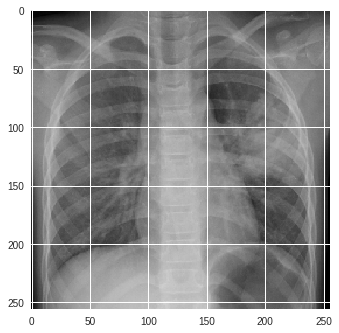

In [ ]:
plt.imshow(img1)
plt.show()

그 후 AI 모델에 넣을 수 있는 형태로 가공하고

In [ ]:
img1 = image.img_to_array(img1)
img1 /= 255.
img1 = img1[np.newaxis, :, :, :]

결과를 확인하면 AI 모델은 다음과 같이 Chest X-ray 라고 정확히 판단합니다. 

In [ ]:
score1 = model.predict(img1)
print('Predicted:', 'Chest X-ray' if score1 < 0.5 else 'Abd X-ray', ', Score:', score1[0,0])

Predicted: Chest X-ray , Score: 0.00030995585


두번째 이미지도 테스트해볼까요?

먼저 이미지를 출력해본 후

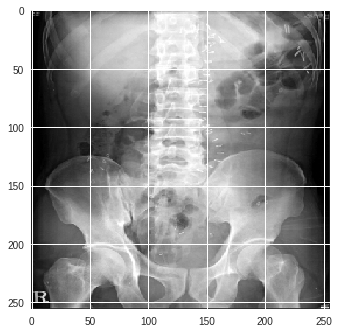

In [ ]:
plt.imshow(img2)
plt.show()

AI 모델에 넣을 준비를 하고

In [ ]:
img2 = image.img_to_array(img2)
img2 /= 255.
img2 = img2[np.newaxis, :, :, :]

예측을 해봅시다!

In [ ]:
score2 = model.predict(img2)
print('Predicted: ', 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray', ', Score:', score2[0,0])

Predicted:  Abd X-ray , Score: 0.9910082
